In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#### Import Kestrel data and change year to 2015

In [26]:
dtypes=[datetime, float]
kes15 = pd.read_excel('Kestrel_data2015.xlsx',names=['time','ws'],header=3)
kes15['time']=kes15['time'].apply((lambda x: x.replace(year=2015)))


start_date = pd.Timestamp(2015,3,11,12,30,0)
end_date = pd.Timestamp(2015,3,11,13,5,0)
mask1 = (kes15['time'] > start_date) & (kes15['time'] <= end_date)
kes15_1 = kes15.loc[mask1]


start_date = pd.Timestamp(2015,3,11,13,10,0)
end_date = pd.Timestamp(2015,3,11,13,30,0)
mask2=(kes15['time'] > start_date) & (kes15['time'] <= end_date)
kes15_2 = kes15.loc[mask2]


#### Import 2015 Pitot data 

In [27]:
pit15_1 = pd.read_csv('WindTunnelCalibration2015_test1.csv',header=0)
pit15_1.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_1['time']=pit15_1['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(year=2015)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(month=3)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(day=11)))

In [28]:
pit15_2=pd.read_csv('WindTunnelCalibration2015_test2.csv',header=0)
pit15_2.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_2['time']=pit15_2['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(year=2015)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(month=3)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(day=11)))
pit15_2.head()

,time,fan_rpm,air_temp,air_dens,press,ws
0,2015-03-11 13:10:00,100,17.1,1.2,20.0,2.6
1,2015-03-11 13:11:00,100,17.1,1.2,20.0,2.6
2,2015-03-11 13:14:00,150,17.2,1.2,45.0,3.8
3,2015-03-11 13:15:00,150,17.2,1.2,45.0,3.8
4,2015-03-11 13:17:00,280,17.1,1.2,NaN,NaN


#### Import 2015 Sonic data 

In [29]:
son15 = pd.read_csv('2015_sonic_1230_start.txt', sep=",", header=None)
son15.columns = ['gu','gv','gw','sound_speed','temp']
N=len(son15)
freq= 10   #Hz
dt= str(1/freq)+'S'   #seconds 
start_time=pd.Timestamp(2015,3,11,12,30,0.0)
time = pd.date_range(start = start_time,periods=N,freq=dt)
son15.insert(0,'time',time,True)
son15 = son15[son15.gu < 20]
son15 = son15[son15.gv < 20]

#### Convert Gill to Met

In [30]:
def convert_gill_to_met(gu,gv,gw):
    w = [x for x in gw]
    u = [-x for x in gv]
    v = [x for x in gu]
    
    return [u,v,w]


def mean_horizontal_wind(u,v):
    mean_winds=[]
    for i in range(len(u)):
        M = np.sqrt((u[i])**2 + (v[i])**2)
        mean_winds.append(M)
    return mean_winds

In [31]:
met_dirs15 = convert_gill_to_met(son15['gu'],son15['gv'],son15['gw'])
u15=met_dirs15[0]
v15=met_dirs15[1]
w15=met_dirs15[2]
M15 = mean_horizontal_wind(u15,v15)
son15.insert(1,'u',u15,True)
son15.insert(2,'v',v15,True)
son15.insert(3,'w',w15,True)
son15.insert(4,'mean_wind',M15,True)
son15.head()

,time,u,v,w,mean_wind,gu,gv,gw,sound_speed,temp
0,2015-03-11 12:30:00.000,2.10,-0.08,0.01,2.101523,-0.08,-2.10,0.01,343.95,20.56
1,2015-03-11 12:30:00.100,2.12,-0.09,0.01,2.121910,-0.09,-2.12,0.01,343.95,20.56
2,2015-03-11 12:30:00.200,2.12,-0.10,0.01,2.122357,-0.10,-2.12,0.01,343.96,20.57
3,2015-03-11 12:30:00.300,2.13,-0.12,0.01,2.133378,-0.12,-2.13,0.01,343.96,20.57
4,2015-03-11 12:30:00.400,2.14,-0.14,0.01,2.144575,-0.14,-2.14,0.01,343.97,20.59


In [32]:
start_date = pd.Timestamp(2015,3,11,12,30,0)
end_date = pd.Timestamp(2015,3,11,13,5,0)
mask1 = (son15['time'] > start_date) & (son15['time'] <= end_date)
son15_1 = son15.loc[mask1]


start_date = pd.Timestamp(2015,3,11,13,10,0)
end_date = pd.Timestamp(2015,3,11,13,30,0)
mask2=(son15['time'] > start_date) & (son15['time'] <= end_date)
son15_2 = son15.loc[mask2]
son15_2.sort_values('mean_wind',ascending=False)
son15_2 = son15_2.drop(25527)
son15_2 = son15_2.drop(34739)

#### Plot wind trace for test 1 2015

Text(0.5,1,'Wind Speed Traces Test 1 2015')

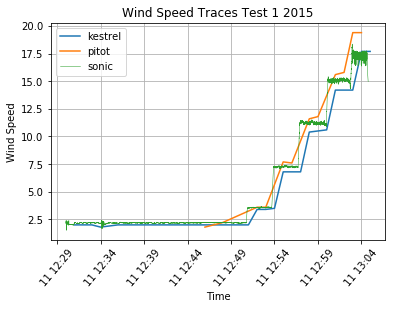

In [33]:
plt.plot(kes15_1['time'],kes15_1['ws'])
plt.plot(pit15_1['time'],pit15_1['ws'])
plt.plot(son15_1['time'],son15_1['mean_wind'],linewidth =0.51)
plt.legend(['kestrel','pitot','sonic'])
plt.xticks(rotation=50)
plt.grid()
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 1 2015')

Text(0.5,1,'Wind Speed Traces Test 2 2015')

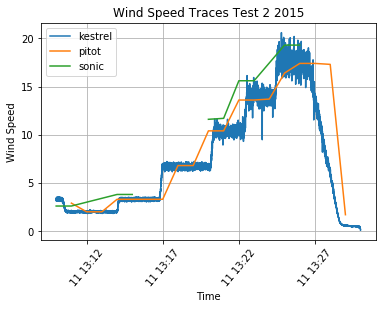

In [34]:
plt.plot(son15_2['time'],son15_2['mean_wind'])
plt.plot(kes15_2['time'],kes15_2['ws'])
plt.plot(pit15_2['time'],pit15_2['ws'])
plt.legend(['kestrel','pitot','sonic'])
plt.xticks(rotation=50)
plt.grid()
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 2 2015')

In [35]:
mask_times = son15.time.isin(pit15_2.time)
son15_times = son15.loc[mask_times]
all_indices = son15_times.index
all_indices

Int64Index([24000, 24600, 26400, 27000, 28200, 28800, 30000, 30600, 31200,
            31800, 33000, 33600],
           dtype='int64')

In [36]:
# son15_avg_2 = pd.DataFrame(columns=['u','v','w','mean_wind','gu','gv','gw','sound_speed','temp'])
# for index_num in all_indices:
#     ten_before_and_after=pd.DataFrame(son15.iloc[all_indices[index_num]-10:all_indices[index_num]+10].mean())
#     son15_avg_2= son15_avg_2.append(ten_before_and_after.T,ignore_index=True)
# son15_avg_2

In [37]:
son15_times

,time,u,v,w,mean_wind,gu,gv,gw,sound_speed,temp
24000,2015-03-11 13:10:00,0.16,-3.20,0.00,3.203998,-3.20,-0.16,0.00,343.33,19.49
24600,2015-03-11 13:11:00,0.17,-2.08,0.06,2.086936,-2.08,-0.17,0.06,343.45,19.70
26400,2015-03-11 13:14:00,0.08,-1.98,-0.03,1.981616,-1.98,-0.08,-0.03,343.51,19.80
27000,2015-03-11 13:15:00,0.12,-3.24,0.02,3.242221,-3.24,-0.12,0.02,343.50,19.78
28200,2015-03-11 13:17:00,0.62,-6.61,0.20,6.639013,-6.61,-0.62,0.20,343.28,19.42
28800,2015-03-11 13:18:00,0.15,-6.73,-0.03,6.731671,-6.73,-0.15,-0.03,343.12,19.14
30000,2015-03-11 13:20:00,0.32,-6.76,-0.07,6.767570,-6.76,-0.32,-0.07,342.89,18.76
30600,2015-03-11 13:21:00,0.91,-10.85,0.19,10.888094,-10.85,-0.91,0.19,343.11,19.12
31200,2015-03-11 13:22:00,-0.17,-10.00,-0.12,10.001445,-10.00,0.17,-0.12,343.07,19.05
31800,2015-03-11 13:23:00,0.77,-15.02,-0.53,15.039724,-15.02,-0.77,-0.53,342.73,18.48


In [38]:
son15_avg_2 = pd.DataFrame(columns=['u','v','w','mean_wind','gu','gv','gw','sound_speed','temp'])
df0=pd.DataFrame(son15.iloc[all_indices[0]-10:all_indices[0]+10].mean())
df1=pd.DataFrame(son15.iloc[all_indices[1]-10:all_indices[1]+10].mean())
df2=pd.DataFrame(son15.iloc[all_indices[2]-10:all_indices[2]+10].mean())
df3=pd.DataFrame(son15.iloc[all_indices[3]-10:all_indices[3]+10].mean())
df4=pd.DataFrame(son15.iloc[all_indices[4]-10:all_indices[4]+10].mean())
df5=pd.DataFrame(son15.iloc[all_indices[5]-10:all_indices[5]+10].mean())
df6=pd.DataFrame(son15.iloc[all_indices[6]-10:all_indices[6]+10].mean())
df7=pd.DataFrame(son15.iloc[all_indices[7]-10:all_indices[7]+10].mean())
df8=pd.DataFrame(son15.iloc[all_indices[8]-10:all_indices[8]+10].mean())
df9=pd.DataFrame(son15.iloc[all_indices[9]-10:all_indices[9]+10].mean())
df10=pd.DataFrame(son15.iloc[all_indices[10]-10:all_indices[10]+10].mean())
df11=pd.DataFrame(son15.iloc[all_indices[11]-10:all_indices[11]+10].mean())

son15_avg_2=son15_avg_2.append(df0.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df1.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df2.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df3.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df4.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df5.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df6.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df7.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df8.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df9.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df10.T,ignore_index=True)
son15_avg_2=son15_avg_2.append(df11.T,ignore_index=True)

In [39]:
time=pit15_2['time']
son15_avg_2.insert(0,'time',time,True)
son15_avg_2

,time,u,v,w,mean_wind,gu,gv,gw,sound_speed,temp
0,2015-03-11 13:10:00,0.0650,-1.9760,0.0215,1.978171,-1.9760,-0.0650,0.0215,343.3875,19.5940
1,2015-03-11 13:11:00,0.0575,-1.9870,0.0160,1.989918,-1.9870,-0.0575,0.0160,343.3915,19.6015
2,2015-03-11 13:14:00,0.1285,-3.2680,0.0275,3.274362,-3.2680,-0.1285,0.0275,343.4375,19.6760
3,2015-03-11 13:15:00,0.1710,-3.2970,0.0330,3.304459,-3.2970,-0.1710,0.0330,343.4695,19.7315
4,2015-03-11 13:17:00,0.2265,-6.6820,0.0750,6.687755,-6.6820,-0.2265,0.0750,343.2245,19.3195
5,2015-03-11 13:18:00,0.2685,-6.7245,0.0880,6.732621,-6.7245,-0.2685,0.0880,343.0535,19.0275
6,2015-03-11 13:20:00,0.3825,-10.3345,0.1990,10.348166,-10.3345,-0.3825,0.1990,343.0230,18.9740
7,2015-03-11 13:21:00,0.3600,-10.3970,0.2325,10.412871,-10.3970,-0.3600,0.2325,343.0155,18.9630
8,2015-03-11 13:22:00,0.6030,-14.2320,0.3390,14.258851,-14.2320,-0.6030,0.3390,342.9230,18.8045
9,2015-03-11 13:23:00,0.2340,-13.8110,0.3815,13.827973,-13.8110,-0.2340,0.3815,343.0870,19.0855


Text(2.6,16.0914,'Sonic Wind Speed= 0.8206x + 0.253')

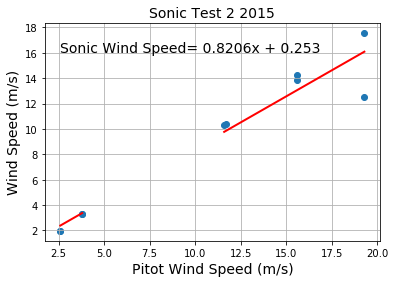

In [61]:
# plt.style.use('seaborn-darkgrid')
x=pit15_2['ws']
y=son15_avg_2['mean_wind']

mask = ~np.isnan(x) & ~np.isnan(y)
stats = linregress(x[mask],y[mask])
m = stats.slope
b = stats.intercept 

# Change the default marker for the scatter from circles to x's
# plt.scatter(x, y, marker='o',color='#003F72')
plt.scatter(x, y, marker='o')
# Set the linewidth on the regression line to 3px
y2= [i*m+b for i in x]
cor = np.corrcoef(x, y)
 
plt.plot(x, y2, color="red", linewidth=2)
plt.xlabel('Pitot Wind Speed (m/s)',fontsize='14')
plt.ylabel('Wind Speed (m/s)',fontsize='14')
plt.title('Sonic Test 2 2015',fontsize='14')        
s= 'Sonic Wind Speed= ' + str(round(m,4))+'x + '+str(round(b,4))
plt.grid(True)
plt.text(min(x),max(y2),s,fontsize='14')

c1 = 1/b
c0= (-1*m)/b

cal_eqn = 'Pitot Wind Speed = ' + str(round(c0,4))+str(round(c1,4))+' Sonic Wind Speed (Test 2)'
print(cal_eqn)

In [62]:
mask_times = son15.time.isin(pit15_1.time)
son15_times = son15.loc[mask_times]
all_indices = son15_times.mindex
all_indices

Int64Index([9600, 10800, 13200, 13800, 15000, 15600, 16800, 17400, 18600,
            19200, 19800],
           dtype='int64')

In [65]:
son15_times
len(son15_times)

11

In [66]:
son15_avg_1 = pd.DataFrame(columns=['u','v','w','mean_wind','gu','gv','gw','sound_speed','temp'])
df0=pd.DataFrame(son15.iloc[all_indices[0]-10:all_indices[0]+10].mean())
df1=pd.DataFrame(son15.iloc[all_indices[1]-10:all_indices[1]+10].mean())
df2=pd.DataFrame(son15.iloc[all_indices[2]-10:all_indices[2]+10].mean())
df3=pd.DataFrame(son15.iloc[all_indices[3]-10:all_indices[3]+10].mean())
df4=pd.DataFrame(son15.iloc[all_indices[4]-10:all_indices[4]+10].mean())
df5=pd.DataFrame(son15.iloc[all_indices[5]-10:all_indices[5]+10].mean())
df6=pd.DataFrame(son15.iloc[all_indices[6]-10:all_indices[6]+10].mean())
df7=pd.DataFrame(son15.iloc[all_indices[7]-10:all_indices[7]+10].mean())
df8=pd.DataFrame(son15.iloc[all_indices[8]-10:all_indices[8]+10].mean())
df9=pd.DataFrame(son15.iloc[all_indices[9]-10:all_indices[9]+10].mean())
df10=pd.DataFrame(son15.iloc[all_indices[10]-10:all_indices[10]+10].mean())
# df11=pd.DataFrame(son15.iloc[all_indices[11]-10:all_indices[11]+10].mean())

son15_avg_1=son15_avg_1.append(df0.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df1.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df2.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df3.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df4.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df5.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df6.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df7.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df8.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df9.T,ignore_index=True)
son15_avg_1=son15_avg_1.append(df10.T,ignore_index=True)
# son15_avg_1=son15_avg_1.append(df11.T,ignore_index=True)

In [67]:
time=pit15_1['time']
son15_avg_1.insert(0,'time',time,True)
son15_avg_1

,time,u,v,w,mean_wind,gu,gv,gw,sound_speed,temp
0,2015-03-11 12:46:00,2.2085,0.0255,0.0180,2.208669,0.0255,-2.2085,0.0180,343.8440,20.3780
1,2015-03-11 12:48:00,2.2005,0.0210,0.0245,2.200621,0.0210,-2.2005,0.0245,343.7095,20.1450
2,2015-03-11 12:52:00,3.5765,0.0350,0.0245,3.576720,0.0350,-3.5765,0.0245,343.8520,20.3870
3,2015-03-11 12:53:00,3.5450,0.0410,0.0320,3.545275,0.0410,-3.5450,0.0320,343.7645,20.2365
4,2015-03-11 12:55:00,7.2655,0.1210,0.0450,7.266582,0.1210,-7.2655,0.0450,343.4450,19.6985
5,2015-03-11 12:56:00,7.2935,0.1180,0.0465,7.294502,0.1180,-7.2935,0.0465,343.5105,19.8115
6,2015-03-11 12:58:00,11.2535,0.2040,0.0950,11.255422,0.2040,-11.2535,0.0950,343.4240,19.6630
7,2015-03-11 12:59:00,11.2225,0.1840,0.0845,11.224060,0.1840,-11.2225,0.0845,343.3060,19.4625
8,2015-03-11 13:01:00,15.1225,0.2930,0.1715,15.125476,0.2930,-15.1225,0.1715,343.2710,19.3980
9,2015-03-11 13:02:00,15.1710,0.3235,0.1890,15.174596,0.3235,-15.1710,0.1890,343.2490,19.3575


In [69]:
pit15_1

,time,fan_rpm,air_temp,air_dens,press,ws
0,2015-03-11 12:46:00,100,17.2,1.2,10,1.8
1,2015-03-11 12:48:00,100,17.3,1.2,15,2.2
2,2015-03-11 12:52:00,150,17.5,1.2,40,3.6
3,2015-03-11 12:53:00,150,17.4,1.2,40,3.6
4,2015-03-11 12:55:00,280,17.3,1.2,180,7.7
5,2015-03-11 12:56:00,280,17.4,1.2,175,7.6
6,2015-03-11 12:58:00,420,17.2,1.2,410,11.6
7,2015-03-11 12:59:00,420,17.2,1.2,420,11.8
8,2015-03-11 13:01:00,560,17.3,1.2,740,15.6
9,2015-03-11 13:02:00,560,17.0,1.2,760,15.8


Text(1.8,16.1565,'Sonic Wind Speed= 0.9173x + 0.3613')

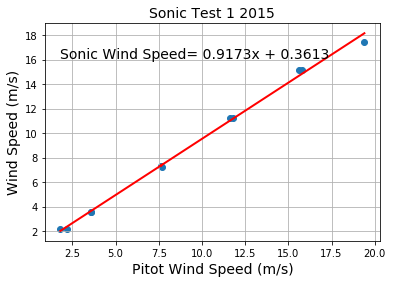

In [72]:
# plt.style.use('seaborn-darkgrid')
x=pit15_1.iloc[:11]['ws']
y=son15_avg_1['mean_wind']

mask = ~np.isnan(x) & ~np.isnan(y)
stats = linregress(x[mask],y[mask])
m = stats.slope
b = stats.intercept 

# Change the default marker for the scatter from circles to x's
# plt.scatter(x, y, marker='o',color='#003F72')
plt.scatter(x, y, marker='o')
# Set the linewidth on the regression line to 3px
y2= [i*m+b for i in x]
cor = np.corrcoef(x, y)
 
plt.plot(x, y2, color="red", linewidth=2)
plt.xlabel('Pitot Wind Speed (m/s)',fontsize='14')
plt.ylabel('Wind Speed (m/s)',fontsize='14')
plt.title('Sonic Test 1 2015',fontsize='14')        
s= 'Sonic Wind Speed= ' + str(round(m,4))+'x + '+str(round(b,4))
plt.grid(True)
plt.text(min(x),max(y2)-2,s,fontsize='14')


c1 = 1/b
c0= (-1*m)/b

cal_eqn ='Pitot Wind Speed = ' + str(round(c0,4))+str(round(c1,4))+' Sonic Wind Speed (Test 1)'
print(cal_eqn)

In [74]:
# mask_times = kes15.time.isin(pit15_1.time)
# kes15_times = kes15.loc[mask_times]
all_indices = kes15_times.index
all_indices

Int64Index([31, 33, 37, 38, 40, 41, 43, 44, 46, 47, 48, 49], dtype='int64')

In [75]:
kes15_times
len(kes15_times)


12

In [76]:
kes15_avg_1 = pd.DataFrame(columns=['ws'])
df0=pd.DataFrame(kes15.iloc[all_indices[0]-10:all_indices[0]+10].mean())
df1=pd.DataFrame(kes15.iloc[all_indices[1]-10:all_indices[1]+10].mean())
df2=pd.DataFrame(kes15.iloc[all_indices[2]-10:all_indices[2]+10].mean())
df3=pd.DataFrame(kes15.iloc[all_indices[3]-10:all_indices[3]+10].mean())
df4=pd.DataFrame(kes15.iloc[all_indices[4]-10:all_indices[4]+10].mean())
df5=pd.DataFrame(kes15.iloc[all_indices[5]-10:all_indices[5]+10].mean())
df6=pd.DataFrame(kes15.iloc[all_indices[6]-10:all_indices[6]+10].mean())
df7=pd.DataFrame(kes15.iloc[all_indices[7]-10:all_indices[7]+10].mean())
df8=pd.DataFrame(kes15.iloc[all_indices[8]-10:all_indices[8]+10].mean())
df9=pd.DataFrame(kes15.iloc[all_indices[9]-10:all_indices[9]+10].mean())
df10=pd.DataFrame(kes15.iloc[all_indices[10]-10:all_indices[10]+10].mean())
df11=pd.DataFrame(kes15.iloc[all_indices[11]-10:all_indices[11]+10].mean())

kes15_avg_1=kes15_avg_1.append(df0.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df1.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df2.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df3.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df4.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df5.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df6.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df7.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df8.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df9.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df10.T,ignore_index=True)
kes15_avg_1=kes15_avg_1.append(df11.T,ignore_index=True)

In [77]:
time=pit15_1['time']
kes15_avg_1.insert(0,'time',time,True)
kes15_avg_1

,time,ws
0,2015-03-11 12:46:00,2.455
1,2015-03-11 12:48:00,2.935
2,2015-03-11 12:52:00,4.820
3,2015-03-11 12:53:00,5.430
4,2015-03-11 12:55:00,6.825
5,2015-03-11 12:56:00,7.610
6,2015-03-11 12:58:00,7.795
7,2015-03-11 12:59:00,7.870
8,2015-03-11 13:01:00,7.985
9,2015-03-11 13:02:00,8.030


Text(2.8,3.455,'Kestrel Wind Speed= 0.264x + 3.8252')

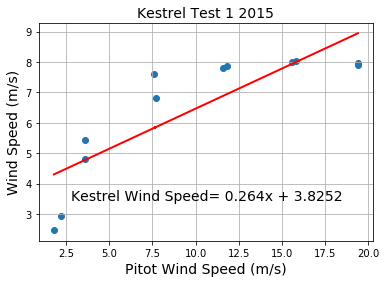

In [83]:
# plt.style.use('seaborn-darkgrid')
x=pit15_1['ws']
y=kes15_avg_1['ws']

mask = ~np.isnan(x) & ~np.isnan(y)
stats = linregress(x[mask],y[mask])
m = stats.slope
b = stats.intercept 

# Change the default marker for the scatter from circles to x's
# plt.scatter(x, y, marker='o',color='#003F72')
plt.scatter(x, y, marker='o')
# Set the linewidth on the regression line to 3px
y2= [i*m+b for i in x]
cor = np.corrcoef(x, y)
 
plt.plot(x, y2, color="red", linewidth=2)
plt.xlabel('Pitot Wind Speed (m/s)',fontsize='14')
plt.ylabel('Wind Speed (m/s)',fontsize='14')
plt.title('Kestrel Test 1 2015',fontsize='14')        
s= 'Kestrel Wind Speed= ' + str(round(m,4))+'x + '+str(round(b,4))
plt.grid(True)
plt.text(min(x)+1,min(y)+1,s,fontsize='14')

c1 = 1/b
c0= (-1*m)/b

cal_eqn ='Pitot Wind Speed = ' + str(round(c0,4))+str(round(c1,4))+' Kestrel Wind Speed (Test 1)'
print(cal_eqn)

In [84]:
mask_times = kes15.time.isin(pit15_2.time)
kes15_times = kes15.loc[mask_times]
all_indices = kes15_times.index
all_indices

Int64Index([55, 56, 59, 60, 62, 63, 65, 66, 67, 68, 70, 71], dtype='int64')

In [85]:
kes15_times
len(kes15_times)


12

In [86]:
kes15_avg_2 = pd.DataFrame(columns=['ws'])
df0=pd.DataFrame(kes15.iloc[all_indices[0]-10:all_indices[0]+10].mean())
df1=pd.DataFrame(kes15.iloc[all_indices[1]-10:all_indices[1]+10].mean())
df2=pd.DataFrame(kes15.iloc[all_indices[2]-10:all_indices[2]+10].mean())
df3=pd.DataFrame(kes15.iloc[all_indices[3]-10:all_indices[3]+10].mean())
df4=pd.DataFrame(kes15.iloc[all_indices[4]-10:all_indices[4]+10].mean())
df5=pd.DataFrame(kes15.iloc[all_indices[5]-10:all_indices[5]+10].mean())
df6=pd.DataFrame(kes15.iloc[all_indices[6]-10:all_indices[6]+10].mean())
df7=pd.DataFrame(kes15.iloc[all_indices[7]-10:all_indices[7]+10].mean())
df8=pd.DataFrame(kes15.iloc[all_indices[8]-10:all_indices[8]+10].mean())
df9=pd.DataFrame(kes15.iloc[all_indices[9]-10:all_indices[9]+10].mean())
df10=pd.DataFrame(kes15.iloc[all_indices[10]-10:all_indices[10]+10].mean())
df11=pd.DataFrame(kes15.iloc[all_indices[11]-10:all_indices[11]+10].mean())

kes15_avg_2=kes15_avg_2.append(df0.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df1.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df2.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df3.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df4.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df5.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df6.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df7.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df8.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df9.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df10.T,ignore_index=True)
kes15_avg_2=kes15_avg_2.append(df11.T,ignore_index=True)

In [87]:
time=pit15_2['time']
kes15_avg_2.insert(0,'time',time,True)
kes15_avg_2

,time,ws
0,2015-03-11 13:10:00,6.990000
1,2015-03-11 13:11:00,6.980000
2,2015-03-11 13:14:00,6.730000
3,2015-03-11 13:15:00,6.530000
4,2015-03-11 13:17:00,7.140000
5,2015-03-11 13:18:00,7.820000
6,2015-03-11 13:20:00,8.430000
7,2015-03-11 13:21:00,8.715789
8,2015-03-11 13:22:00,9.038889
9,2015-03-11 13:23:00,9.452941


Text(2.6,10.1643,'Kestrel Wind Speed= 0.2218x + 6.0608')

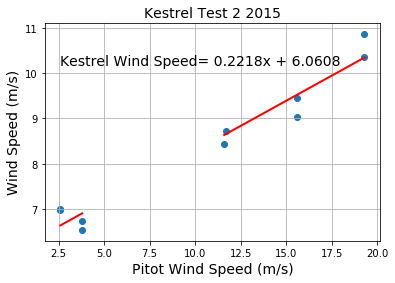

In [90]:
# plt.style.use('seaborn-darkgrid')
x=pit15_2['ws']
y=kes15_avg_2['ws']

mask = ~np.isnan(x) & ~np.isnan(y)
stats = linregress(x[mask],y[mask])
m = stats.slope
b = stats.intercept 

# Change the default marker for the scatter from circles to x's
# plt.scatter(x, y, marker='o',color='#003F72')
plt.scatter(x, y, marker='o')
# Set the linewidth on the regression line to 3px
y2= [i*m+b for i in x]
cor = np.corrcoef(x, y)
 
plt.plot(x, y2, color="red", linewidth=2)
plt.xlabel('Pitot Wind Speed (m/s)',fontsize='14')
plt.ylabel('Wind Speed (m/s)',fontsize='14')
plt.title('Kestrel Test 2 2015',fontsize='14')        
s= 'Kestrel Wind Speed= ' + str(round(m,4))+'x + '+str(round(b,4))
plt.grid(True)
plt.text(min(x),max(y)-0.7,s,fontsize='14')

c1 = 1/b
c0= (-1*m)/b

cal_eqn ='Pitot Wind Speed = ' + str(round(c0,4))+str(round(c1,4))+' Kestrel Wind Speed (Test 2)'
print(cal_eqn)

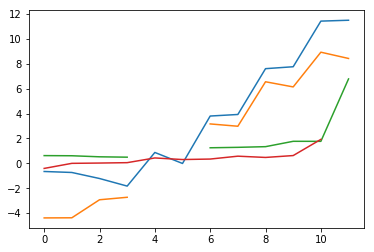

In [94]:
bias_kes_1= pit15_1['ws'] - kes15_avg_1['ws']
bias_kes_2= pit15_2['ws'] - kes15_avg_2['ws']
bias_son_1= pit15_1.iloc[:11]['ws'] - son15_avg_1['mean_wind']
bias_son_2= pit15_2['ws'] - son15_avg_2['mean_wind']

plt.plot(bias_kes_1)
plt.plot(bias_kes_2)
plt.plot(bias_son_2)
plt.plot(bias_son_1)

#### Sonic 1 min average average

In [41]:
# son15_1.index = pd.DatetimeIndex(son15_1.time)
# avg_time = '60S'
# u = (son15_1['u'].resample(avg_time).mean())
# v = (son15_1['v'].resample(avg_time).mean())
# w = (son15_1['w'].resample(avg_time).mean())
# mean_wind = (son15_1['mean_wind'].resample(avg_time).mean())
# gu = (son15_1['gu'].resample(avg_time).mean())
# gv = (son15_1['gv'].resample(avg_time).mean())
# gw = (son15_1['gw'].resample(avg_time).mean())
# sound_speed = (son15_1['sound_speed'].resample(avg_time).mean())
# temp = (son15_1['temp'].resample(avg_time).mean())
# data = {'u':u,
#         'v':v,
#         'w':w,
#         'mean_wind':mean_wind,
#         'gu':gu, 
#         'gv':gv,
#         'gw':gw,
#         'sound_speed':sound_speed,
#         'temp':temp} 
# son15_1_avg=pd.DataFrame(data)
# son15_1_avg.head()

In [42]:
# son15_2.index = pd.DatetimeIndex(son15_2.time)
# avg_time = '60S'
# u = (son15_2['u'].resample(avg_time).mean())
# v = (son15_2['v'].resample(avg_time).mean())
# w = (son15_2['w'].resample(avg_time).mean())
# mean_wind = (son15_2['mean_wind'].resample(avg_time).mean())
# gu = (son15_2['gu'].resample(avg_time).mean())
# gv = (son15_2['gv'].resample(avg_time).mean())
# gw = (son15_2['gw'].resample(avg_time).mean())
# sound_speed = (son15_2['sound_speed'].resample(avg_time).mean())
# temp = (son15_2['temp'].resample(avg_time).mean())
# data = {'u':u,
#         'v':v,
#         'w':w,
#         'mean_wind':mean_wind,
#         'gu':gu, 
#         'gv':gv,
#         'gw':gw,
#         'sound_speed':sound_speed,
#         'temp':temp} 
# son15_2_avg=pd.DataFrame(data)
# son15_2_avg.head()

#### Import 2020 Kestrel data 

In [43]:
kes20 = pd.read_csv('kestrel_2020.csv',names=['time','ws'],header=0)
kes20['time'] = pd.to_datetime(kes20['time'])
start_date = pd.Timestamp(2020,3,6,11,50,0)
end_date = pd.Timestamp(2020,3,6,12,15,37)
mask1 = (kes20['time'] > start_date) & (kes20['time'] <= end_date)
kes20 = kes20.loc[mask1]

#### Import 2020 Sonic data 

In [44]:
son20 = pd.read_csv('sonic_2020.csv', header=None)
son20.columns = ['gu','gv','gw','sound_speed','temp']
N=len(son20)
freq= 10   #Hz
dt= str(1/freq)+'S'   #seconds 


start_time=pd.Timestamp(2020,3,6,11,50,0)
time = pd.date_range(start = start_time,periods=N,freq=dt)
son20.insert(0,'time',time,True)
met_dirs20 = convert_gill_to_met(son20['gu'],son20['gv'],son20['gw'])
u20=met_dirs20[0]
v20=met_dirs20[1]
w20=met_dirs20[2]
M20 = mean_horizontal_wind(u20,v20)

son20.insert(1,'u',u20,True)
son20.insert(2,'v',v20,True)
son20.insert(3,'w',w20,True)
son20.insert(4,'mean_wind',M20,True)

son20.sort_values('mean_wind',ascending=False).head()
son20 = son20.drop(13879)
son20 = son20.drop(15580)
son20 = son20.drop(3415)
son20 = son20.drop(14271)
son20 = son20.drop(9264)
son20 = son20.drop(12100)

start_date = pd.Timestamp(2020,3,6,11,50,0)
end_date = pd.Timestamp(2020,3,6,12,15,37)
mask2=(son20['time'] > start_date) & (son20['time'] <= end_date)
son20 = son20.loc[mask2]

#### Plot wind trace for test 2 2020

Text(0.5,1,'Wind Speed Traces Test 2 2020')

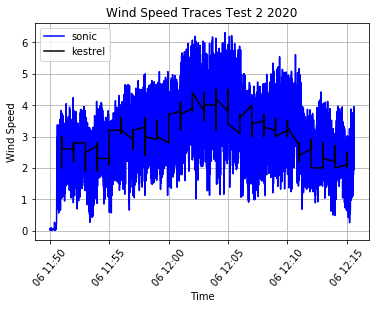

In [45]:
plt.plot(son20['time'],son20['mean_wind'],c='b')
plt.plot(kes20['time'],kes20['ws'],c='k')
plt.legend(['sonic','kestrel'])
plt.xticks(rotation=50)
plt.grid()
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 2 2020')


In [46]:
def find_alpha(u,v):
    dirs=[]
    for i in np.arange(len(u)):
        
        if u.iloc[i] > 0.0:
            alpha = 90 - np.arctan(v.iloc[i]/u.iloc[i])+180
        else:
            alpha = 90 - np.arctan(v.iloc[i]/u.iloc[i])

        dirs.append(alpha)

    return dirs

np.mean(find_alpha(son20['u'],son20['v']))

90.8351366961003

#### Average Kestrel and Sonic data

In [47]:
kes20 = pd.read_csv('kestrel_2020.csv',names=['time','ws'],header=0)
kes20['time'] = pd.to_datetime(kes20['time'])

## OFF TO LOW
end_date = pd.Timestamp(2020,3,6,11,50,0)
mask1 = (kes20['time'] <= end_date)
kes20_1 = kes20.loc[mask1]


kes20_1.index = pd.DatetimeIndex(kes20_1.time)
avg_time = '60S'
ws = (kes20_1['ws'].resample(avg_time).mean())
data = {'ws':ws} 
kes20_avg_1=pd.DataFrame(data)
kes20_avg_1

## LOW TO OFF
start_date = pd.Timestamp(2020,3,6,12,10,35)
end_date = pd.Timestamp(2020,3,6,12,15,37)
mask2 = (kes20['time'] > start_date) & (kes20['time'] <= end_date)
kes20_2 = kes20.loc[mask2]


kes20_2.index = pd.DatetimeIndex(kes20_2.time)
avg_time = '60S'
ws = (kes20_2['ws'].resample(avg_time).mean())
data = {'ws':ws} 
kes20_avg_2=pd.DataFrame(data)
kes20_avg_1

,ws
time,
2020-03-06 11:49:00,0.000000
2020-03-06 11:50:00,1.316667


In [48]:
son20.index = pd.DatetimeIndex(son20.time)
avg_time = '60S'
u = (son20['u'].resample(avg_time).mean())
v = (son20['v'].resample(avg_time).mean())
w = (son20['w'].resample(avg_time).mean())
mean_wind = (son20['mean_wind'].resample(avg_time).mean())
gu = (son20['gu'].resample(avg_time).mean())
gv = (son20['gv'].resample(avg_time).mean())
gw = (son20['gw'].resample(avg_time).mean())
sound_speed = (son20['sound_speed'].resample(avg_time).mean())
temp = (son20['temp'].resample(avg_time).mean())

data = {'u':u,
        'v':v,
        'w':w,
        'mean_wind':mean_wind,
        'gu':gu, 
        'gv':gv,
        'gw':gw,
        'sound_speed':sound_speed,
        'temp':temp} 
son20_avg=pd.DataFrame(data)









kes20 = pd.read_csv('kestrel_2020.csv',names=['time','ws'],header=0)
kes20['time'] = pd.to_datetime(kes20['time'])

## OFF TO LOW
end_date = pd.Timestamp(2020,3,6,11,50,0)
mask1 = (kes20['time'] <= end_date)
kes20_1 = kes20.loc[mask1]


kes20_1.index = pd.DatetimeIndex(kes20_1.time)
avg_time = '60S'
ws = (kes20_1['ws'].resample(avg_time).mean())
data = {'ws':ws} 
kes20_avg_1=pd.DataFrame(data)
kes20_avg_1

## LOW TO OFF
start_date = pd.Timestamp(2020,3,6,12,10,35)
end_date = pd.Timestamp(2020,3,6,12,15,37)
mask2 = (kes20['time'] > start_date) & (kes20['time'] <= end_date)
kes20_2 = kes20.loc[mask2]


kes20_2.index = pd.DatetimeIndex(kes20_2.time)
avg_time = '60S'
ws0 = (kes20_2['ws'].resample(avg_time).mean())
data = {'ws':ws} 
kes20_avg_2=pd.DataFrame(data)
kes20_avg_1

,ws
time,
2020-03-06 11:49:00,0.000000
2020-03-06 11:50:00,1.316667
